In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.utils.data as data_utils
import random
from copy import deepcopy


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # Change from 1 to 3 input channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)  # Adjust the size for CIFAR-10
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)  # Adjust the size for CIFAR-10
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def create_non_iid_partitions(dataset, num_clients, additional_samples_per_client=100):
    num_classes = 10
    class_indices = [[] for _ in range(num_classes)]
    
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    # Ensure randomness in class selection for each client
    all_classes = list(range(num_classes))
    
    client_local_datasets = []
    for i in range(num_clients):
        # Randomly select two major classes for each client
        major_classes = random.sample(all_classes, 2)

        # Allocate all data from the two major classes
        client_indices = class_indices[major_classes[0]] + class_indices[major_classes[1]]
        
        #Add a small number of samples from other classes
        minor_indices = []
        for cls in set(range(num_classes)) - set(major_classes):
            n_samples = len(class_indices[cls]) // num_clients // statistical_heterogeneity  # 50 times less than major classes
            minor_indices.extend(class_indices[cls][i * n_samples: (i + 1) * n_samples])

        client_indices = client_indices + minor_indices
        random.shuffle(client_indices)  # Shuffle to mix data from different classes
        client_local_datasets.append(data_utils.Subset(dataset, client_indices))

    return client_local_datasets

def create_iid_partitions(dataset, num_clients):

    client_datasets = []
    for i in range(num_clients):
        client_dataset = data_utils.Subset(dataset, list(range(i * len(dataset) // num_clients, (i + 1) * len(dataset) // num_clients)))
        client_datasets.append(client_dataset)
    return client_datasets

def server_aggregate(state_dict_list):
    # average the model
    aggregated_state = {}
    for key,parameter in model.named_parameters():
        tensor_to_aggregate = []
        for client_state_dict in state_dict_list:
            client_tensor = client_state_dict[key].float()
            tensor_to_aggregate.append(client_tensor)
        
        stacked_tensor = torch.stack(tensor_to_aggregate,dim=0)
        mean_tensor = torch.mean(stacked_tensor,dim=0)
        aggregated_state[key] = mean_tensor
    model.load_state_dict(aggregated_state)

    return model 

def difference_models_norm_2(local_model, initial_model):
    tensor_1 = list(local_model.parameters())
    tensor_2 = list(initial_model.parameters())
    sub_norm = []
    for i in range(len(tensor_1)):
        s = torch.norm(tensor_1[i].to(myGPU) - tensor_2[i].to(myGPU),p=2)
        sub_norm.append(s)
    return sum(sub_norm)

def client_update(received_model, train_data, local_optimizer, loss_f, epoch,client_id,mu,sigma,loss_difference,last_global_loss,algorithm,sys_heter):

    local_model = received_model.to(myGPU)
    initial_model = received_model.to(myGPU)
    
    random_chance = random.randint(0, 10) # Randomly decide if the client is weak or strong
    if random_chance > sys_heter or algorithm == "FedProx": # In fedprox, all clients train, those weaker clients will train less according to sigma; In FedAvg, only strong clients train
        
        # if a client is strong in FedAvg, perform full training, if not drop it; in FedProx, all clients train and the amount of training is determined by sigma
    
        print(f"Client {client_id+1} starts training...")
        print(f"losss difference: {loss_difference}")
        print(f"last global loss: {last_global_loss}")
        model.train()
        
        
        
        for i in range(epoch):
            running_loss = 0.0
            
            for feature, label in train_data:
                local_optimizer.zero_grad()
                feature, label = feature.to(myGPU), label.to(myGPU)
                outputs = local_model(feature)
                local_loss = loss_f(outputs, label)
                loss_prox = (mu / 2) * difference_models_norm_2(local_model, initial_model) # perform model updates penalization using proximal term
                loss = local_loss + loss_prox
                loss.backward()
                local_optimizer.step()
                running_loss += loss.item()
            if (abs(running_loss / len(train_data) - last_global_loss) < sigma*abs(loss_difference) or running_loss / len(train_data) < sigma*loss_difference) and algorithm == "FedProx": # allow good enough results for all clients
                
                print(f"Client {client_id+1} stops training at epoch {i+1} because good enough results hve been obtained at Loss: {running_loss / len(train_data)}")
                break
            print(running_loss / len(train_data) < sigma*loss_difference)
            print(f"Epoch {i+1} loss: {running_loss / len(train_data)}")
        print("\n")
        return model.state_dict()
    
    
    else: # If the client is weak, it will not train
        print(f"Client {client_id+1} dropped")
        return model.state_dict()


def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_feature, test_labels in testloader:
         
            test_feature, test_labels = test_feature.to(myGPU), test_labels.to(myGPU)
            outputs = model(test_feature)
            test_loss = loss_function(outputs, test_labels)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
            test_loss += test_loss.item()
    accuracy = 100 * correct / total
    loss = test_loss / len(testloader)

    print(f"Accuracy of the network: {accuracy}, Loss: {loss}")
    return [accuracy, loss]



def federated_learning(model, mu, sigma,client_datasets, testloader, optimizer, loss_function, global_epochs, local_epochs,algorithm,sys_heter):
    
    for i, client_dataset in enumerate(client_datasets):
        client_labels = [trainset.targets[idx] for idx in client_dataset.indices]  # Access the labels for each subset
        unique_labels = np.unique(client_labels)
        print(f"Client {i} has {len(unique_labels)} unique labels: {unique_labels}, and {len(client_dataset)} samples")
        
    initial_phase = evaluate(model, testloader)
    loss_difference = 0
    global_loss = initial_phase[1]
    print(f"Initial loss: {global_loss} Accuracy: {initial_phase[0]}")        
    print("Training Starting .......")
    print("\n")
    
    # Create a dataloader for each client
    client_dataloaders = [data_utils.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2) for dataset in client_datasets]
    global_history = []
    for global_epoch in range(global_epochs):
        
        print(f" ====================== Global Round {global_epoch+1} ======================")
        state_dicts = []
        for client_id, client_dataloader in enumerate(client_dataloaders):
            
            client_state_dict = client_update(model, client_dataloader, optimizer, loss_function, local_epochs,client_id,mu,sigma,loss_difference,global_loss,algorithm,sys_heter)
            state_dicts.append(client_state_dict)
        
        global_model = server_aggregate(state_dicts)
        model.load_state_dict(global_model.state_dict())
        
        
        # This one is to find the deviation between current global model and the previous global model. Note that our sigma will adjust this deviation to determine the amount of training for each client
        one_global_hist = evaluate(model, testloader)
        loss_difference = one_global_hist[1] - global_loss
        global_loss = one_global_hist[1]
        print(f"Loss difference: {loss_difference}")
        print(f"Global Round {global_epoch+1} ends")
        print("\n")
        
        global_history.append(one_global_hist)
        
    return global_history


# Training set up using CIFAR-10

In [2]:
myGPU = torch.device("cpu")
model = CNN().to(myGPU)
# load the data
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB channels
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
global_epochs = 20
local_epochs = 10
number_of_clients = 5
    

Files already downloaded and verified
Files already downloaded and verified


# Training without System and Statistical Homogeneity

In [3]:
# Federated Average without system and statistical heterogeneity
client_datasets=create_iid_partitions(trainset, number_of_clients)
# Note that FedAvg is a special case of FedProx when mu = 0 and sigma = 1
mu=0
sigma=0
algorithm = "FedAvg"
system_heterogeneity=0
avg_iid_history = federated_learning(model,mu,sigma,client_datasets, testloader,optimizer, loss_function, global_epochs, local_epochs,algorithm,system_heterogeneity)

Client 0 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10000 samples
Client 1 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10000 samples
Client 2 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10000 samples
Client 3 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10000 samples
Client 4 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10000 samples


Accuracy of the network: 10.0, Loss: 0.11488183587789536
Initial loss: 0.11488183587789536 Accuracy: 10.0
Training Starting .......


 ====================== Global Round 1 ======================
Client 1 starts training...
losss difference: 0
last global loss: 0.11488183587789536


KeyboardInterrupt: 

# Training Under System and Statistical Heterogeneity

In [5]:
statistical_heterogeneity=10
system_heterogeneity=9
client_datasets=create_non_iid_partitions(trainset, number_of_clients,statistical_heterogeneity)
print("\n")

# Federated Proximal with system and statistical heterogeneity
mu = 0.01
sigma = 0.8
algorithm = "FedProx"
prox_niid_history=federated_learning(model,mu,sigma,client_datasets, testloader,optimizer, loss_function, global_epochs, local_epochs,algorithm,system_heterogeneity)

# Federated Proximal with system and statistical heterogeneity
algorithm = "FedAvg"
mu = 0 
sigma = 1
avg_niid_history=federated_learning(model,mu,sigma,client_datasets, testloader,optimizer, loss_function, global_epochs, local_epochs,algorithm,system_heterogeneity)
    



Client 0 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10800 samples
Client 1 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10800 samples
Client 2 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10800 samples
Client 3 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10800 samples
Client 4 has 10 unique labels: [0 1 2 3 4 5 6 7 8 9], and 10800 samples
Accuracy of the network: 46.33, Loss: 0.14370417594909668
Initial loss: 0.14370417594909668 Accuracy: 46.33
Training Starting .......


 ====================== Global Round 1 ======================
Client 1 starts training...
losss difference: 0
last global loss: 0.14370417594909668
False
Epoch 1 loss: 0.5458359690599663
False
Epoch 2 loss: 0.35089088006075037
False
Epoch 3 loss: 0.28749109977899595
False
Epoch 4 loss: 0.24882183345251305
False
Epoch 5 loss: 0.21276561881220618
False
Epoch 6 loss: 0.1872454167798508
False
Epoch 7 loss: 0.14787570491086605
False
Epoch 8 loss: 0.12326646890751151
False
Epoch 9 loss: 0.10014725493830

KeyboardInterrupt: 

# plotting the results

In [ ]:
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np


# No heterogeneity
fedAvg_iid_acc = [avg_iid_history[i][0] for i in range(global_epochs)]

fedProx_niid_acc = [prox_niid_history[i][0] for i in range(global_epochs)]

fedAvg_niid_acc = [avg_niid_history[i][0] for i in range(global_epochs)]




# No heterogeneity results

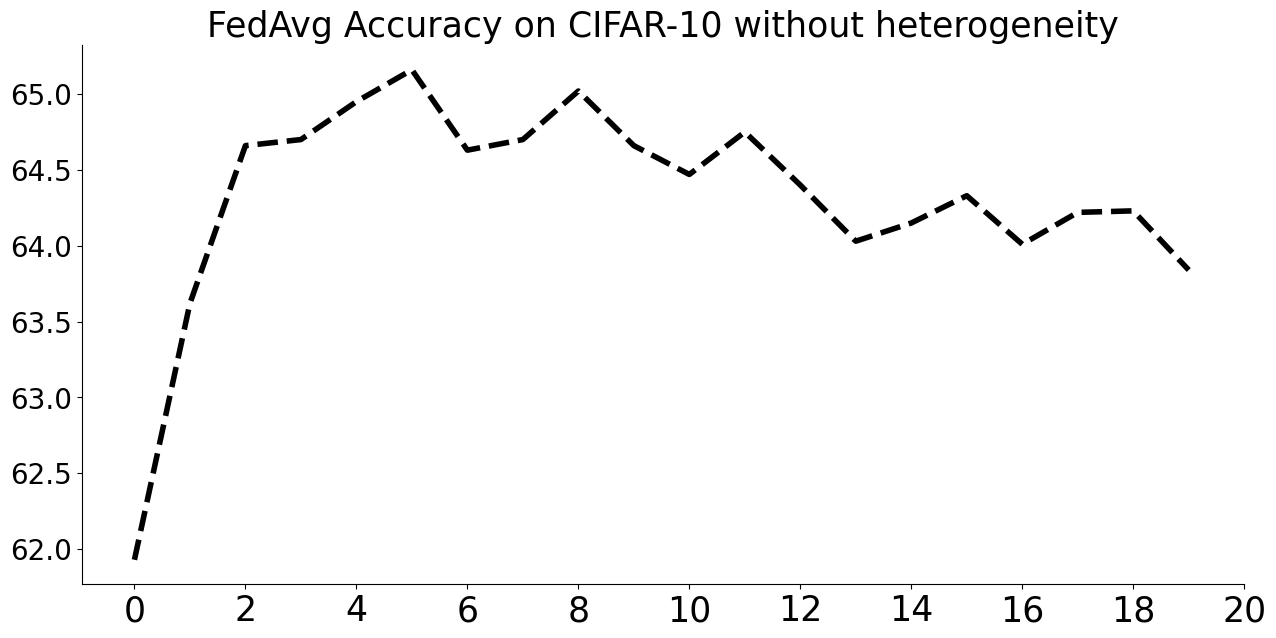

In [ ]:
n_iter = 22
plt.figure(figsize=(15, 7),facecolor='white')
plt.title('FedAvg Accuracy on CIFAR-10 without heterogeneity',fontsize=25,color='black')
plt.plot(fedAvg_iid_acc, label='Fed_avg', color="black", linestyle="dashed", linewidth=4)
plt.xticks(np.arange(0, n_iter, 2),fontsize=25,color='black')
plt.yticks(fontsize=20,color='black')
ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_facecolor('white')
plt.show()

# With heterogeneity results

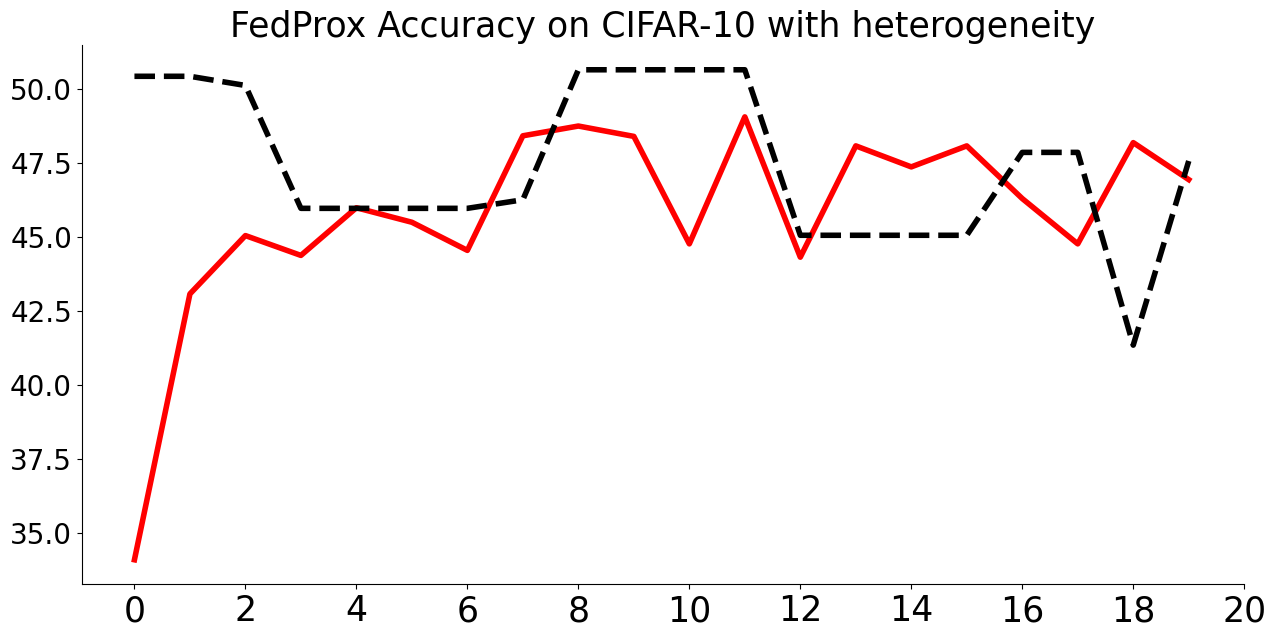

In [ ]:
plt.figure(figsize=(15, 7),facecolor='white')
plt.title('FedProx Accuracy on CIFAR-10 with heterogeneity',fontsize=25,color='black')
plt.plot(fedProx_niid_acc, label='Fed_prox', color="red", linestyle="solid", linewidth=4)
plt.plot(fedAvg_niid_acc, label='Fed_avg', color="black", linestyle="dashed", linewidth=4)
plt.xticks(np.arange(0, n_iter, 2),fontsize=25,color='black')
plt.yticks(fontsize=20,color='black')
ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_facecolor('white')
plt.show()

# 